In [1]:
import numpy as np
import pennylane as qml
import random
import sys
import torch
import itertools
import scipy.stats
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

C:\Users\Public\New folder\envs\QML\Lib\site-packages\pennylane\capture\capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.4.33 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [2]:
n_qubits = 4
dev1 = qml.device("default.qubit", wires=n_qubits)   #no edges
dev2 = qml.device("default.qubit", wires=n_qubits)
dev3 = qml.device("default.qubit", wires=n_qubits)
dev4 = qml.device("default.qubit", wires=n_qubits)
dev5 = qml.device("default.qubit", wires=n_qubits)
dev6 = qml.device("default.qubit", wires=n_qubits) 
dev7 = qml.device("default.qubit", wires=n_qubits)
dev8 = qml.device("default.qubit", wires=n_qubits)
dev9 = qml.device("default.qubit", wires=n_qubits)
dev10 = qml.device("default.qubit", wires=n_qubits)
dev11 = qml.device("default.qubit", wires=n_qubits)   

base_edges2 = [(0,1)]
base_edges3 = [(0, 1), (2, 3)]
base_edges4 = [(0,1),(1,3)]
base_edges5 = [(0,1),(1,3),(3,2)]
base_edges6 = [(0,1),(2,1),(3,1)]
base_edges7 = [(0,1),(0,2),(0,3),(2,3)]
base_edges8 = [(0,2),(0,3),(2,3)]
base_edges9 = [(0,1),(1,3),(3,2),(2,0)]
base_edges10 = [(0,1),(1,3),(3,2),(2,0),(0,3)]
base_edges11 = [(0,1),(1,3),(3,2),(2,0),(0,3),(1,2)]

# All 24 permutations of [0, 1, 2, 3]
permutations = list(itertools.permutations(range(n_qubits)))

@qml.qnode(dev1)
def run_permuted_graph_state1(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    return qml.state()


@qml.qnode(dev2)
def run_permuted_graph_state2(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    for (a, b) in base_edges2:
        qa = permutation[a]
        qb = permutation[b]
        qml.CZ(wires=[qa, qb])
    return qml.state()

@qml.qnode(dev3)
def run_permuted_graph_state3(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    for (a, b) in base_edges3:
        qa = permutation[a]
        qb = permutation[b]
        qml.CZ(wires=[qa, qb])
    return qml.state()

@qml.qnode(dev4)
def run_permuted_graph_state4(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    for (a, b) in base_edges4:
        qa = permutation[a]
        qb = permutation[b]
        qml.CZ(wires=[qa, qb])
    return qml.state()

@qml.qnode(dev5)
def run_permuted_graph_state5(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    for (a, b) in base_edges5:
        qa = permutation[a]
        qb = permutation[b]
        qml.CZ(wires=[qa, qb])
    return qml.state()

@qml.qnode(dev6)
def run_permuted_graph_state6(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    for (a, b) in base_edges6:
        qa = permutation[a]
        qb = permutation[b]
        qml.CZ(wires=[qa, qb])
    return qml.state()

@qml.qnode(dev7)
def run_permuted_graph_state7(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    for (a, b) in base_edges7:
        qa = permutation[a]
        qb = permutation[b]
        qml.CZ(wires=[qa, qb])
    return qml.state()

@qml.qnode(dev8)
def run_permuted_graph_state8(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    for (a, b) in base_edges8:
        qa = permutation[a]
        qb = permutation[b]
        qml.CZ(wires=[qa, qb])
    return qml.state()

@qml.qnode(dev9)
def run_permuted_graph_state9(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    for (a, b) in base_edges9:
        qa = permutation[a]
        qb = permutation[b]
        qml.CZ(wires=[qa, qb])
    return qml.state()

@qml.qnode(dev10)
def run_permuted_graph_state10(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    for (a, b) in base_edges10:
        qa = permutation[a]
        qb = permutation[b]
        qml.CZ(wires=[qa, qb])
    return qml.state()

@qml.qnode(dev11)
def run_permuted_graph_state11(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    for (a, b) in base_edges11:
        qa = permutation[a]
        qb = permutation[b]
        qml.CZ(wires=[qa, qb])
    return qml.state()

states1 = []
for perm in permutations:
    state1 = run_permuted_graph_state1(perm)
    states1.append(state1)
states1 = np.array(states1, dtype=np.complex64)

states2 = []
for perm in permutations:
    state2 = run_permuted_graph_state2(perm)
    states2.append(state2)
states2 = np.array(states2, dtype=np.complex64)

states3 = []
for perm in permutations:
    state3 = run_permuted_graph_state3(perm)
    states3.append(state3)
states3 = np.array(states3, dtype=np.complex64)

states4 = []
for perm in permutations:
    state4 = run_permuted_graph_state4(perm)
    states4.append(state4)
states4 = np.array(states4, dtype=np.complex64)

states5 = []
for perm in permutations:
    state5 = run_permuted_graph_state5(perm)
    states5.append(state5)
states5 = np.array(states5, dtype=np.complex64)

states6 = []
for perm in permutations:
    state6 = run_permuted_graph_state6(perm)
    states6.append(state6)
states6 = np.array(states6, dtype=np.complex64)

states7 = []
for perm in permutations:
    state7 = run_permuted_graph_state7(perm)
    states7.append(state7)
states7 = np.array(states7, dtype=np.complex64)

states8 = []
for perm in permutations:
    state8 = run_permuted_graph_state8(perm)
    states8.append(state8)
states8 = np.array(states8, dtype=np.complex64)

states9 = []
for perm in permutations:
    state9 = run_permuted_graph_state9(perm)
    states9.append(state9)
states9 = np.array(states9, dtype=np.complex64)

states10 = []
for perm in permutations:
    state10 = run_permuted_graph_state10(perm)
    states10.append(state10)
states10 = np.array(states10, dtype=np.complex64)

states11 = []
for perm in permutations:
    state11 = run_permuted_graph_state11(perm)
    states11.append(state11)
states11 = np.array(states11, dtype=np.complex64)

print(len(states1), len(states2), len(states3), len(states4), len(states5), len(states6), len(states7), len(states8), len(states9), len(states10), len(states11))

24 24 24 24 24 24 24 24 24 24 24


In [3]:
def QuantumStateDataset(states1, states2, states3, states4, states5, states6, num_samples=70):
    data = []
    labels = []

    for _ in range(num_samples):
        
        for i in range(24):
            
            first_state = states1[i]      # Class no. 1
            second_state = states2[i]     # Class no. 2
            third_state = states3[i]      # Class no. 3
            fourth_state = states4[i]     # Class no. 4
            fifth_state = states5[i]      # Class no. 5
            sixth_state = states6[i]      # Class no. 6
            seventh_state = states7[i]    # Class no. 5
            eighth_state = states8[i]     # Class no. 4
            ninth_state = states9[i]      # Class no. 5
            tenth_state = states10[i]     # Class no. 5
            eleventh_state = states11[i]  # Class no. 6
    
            zero_label_states = [(fifth_state, 0), (seventh_state, 0), (tenth_state, 0), ( ninth_state, 0)]
            one_label_states = [(sixth_state, 1), (eleventh_state, 1), (first_state, 1),  (second_state, 1), 
                                 (third_state, 1), (fourth_state, 1), (eighth_state, 1)]

            if random.random() < 0.5:
                initial_state, label = random.choice(zero_label_states)
            else:
                initial_state, label = random.choice(one_label_states)
                
            resulting_state = initial_state
            norm = np.linalg.norm(resulting_state)
            normalized_resulting_state = resulting_state / norm
            data.append(normalized_resulting_state)
            labels.append(label)
    return data, labels

class QuantumStateTorchDataset(Dataset):
    def __init__(self, states, labels):
        self.states = torch.tensor(states.real, dtype=torch.complex64)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.states[idx], self.labels[idx]

class RealOutputWrapper(torch.nn.Module):
    def __init__(self, qlayer):
        super().__init__()
        self.qlayer = qlayer

    def forward(self, x):
        q_out = self.qlayer(x)
        return q_out.real  
        
def accuracy(X, Y):
    predictions = torch.sign(X)
    acc = ((predictions+Y)**2)/4
    return acc

In [4]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)
def variational_circuit(weights, inputs):
    qml.templates.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))]

@qml.qnode(dev)
def quantum_model(weights, inputs):
    return variational_circuit(weights, inputs)

In [5]:
X_train_o, y_train_o = QuantumStateDataset(states1, states2, states3, states4, states5, states6, num_samples=220)
X_test_o, y_test_o = QuantumStateDataset(states1, states2, states3, states4, states5, states6, num_samples=220)

X_train= np.array(X_train_o)
y_train = np.array(y_train_o)
y_train = y_train.reshape(-1,1)
X_test= np.array(X_test_o)
y_test = np.array(y_test_o)
y_test = y_test.reshape(-1,1)

y_train = y_train * 2 - 1  
y_test = y_test * 2 - 1
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#print(X_train, X_test, y_train, y_test)

(5280, 16) (5280, 16) (5280, 1) (5280, 1)


In [6]:
num_layers = 4
lr=0.001
weight_shapes = {"weights": (num_layers, n_qubits, 3)}

num_epochs = 400
batch_size = 10
batches = (X_train.shape[0]) // batch_size
batches_test = (X_test.shape[0]) // batch_size

train_dataset = QuantumStateTorchDataset(X_train, y_train)
test_dataset = QuantumStateTorchDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
qlayer = qml.qnn.TorchLayer(quantum_model, weight_shapes)
clayer1 = torch.nn.Linear(4, 200)
clayer2 = torch.nn.Linear(200, 1)
tanh = torch.nn.Tanh()
model = torch.nn.Sequential(RealOutputWrapper(qlayer) , clayer1, tanh, clayer2, tanh)
opt = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.MSELoss()

In [8]:
epoch_list = []
loss_list = []
train_acc_list = []
test_acc_list = []
train_auc_list=[]
test_auc_list=[]

In [9]:
for epoch in range(num_epochs):

    running_loss = 0

    for x, y in train_loader:
        opt.zero_grad()
        # print(model(x).shape)
        # print(y.shape)
        # print(model(x).dtype)
        # print(y.dtype)
        loss_evaluated = loss(model(x), y)
        loss_evaluated.backward()
        
        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    loss_list.append(avg_loss.item())
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

Average loss over epoch 1: 0.4892
Average loss over epoch 2: 0.0953
Average loss over epoch 3: 0.0147
Average loss over epoch 4: 0.0033


KeyboardInterrupt: 

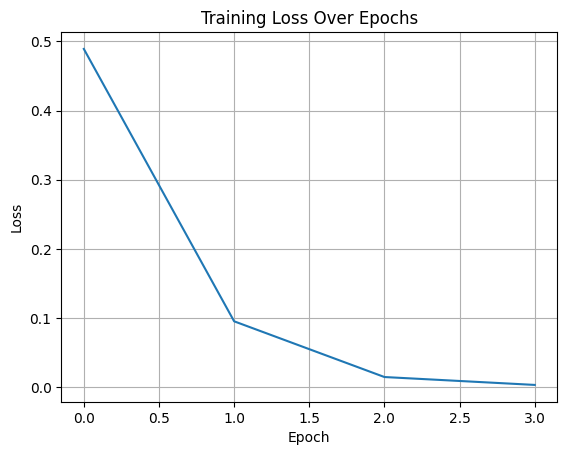

In [10]:
plt.plot(loss_list)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [11]:
running_loss=0
for x, y in train_loader:
        loss_evaluated = loss(model(x), y)
        running_loss += loss_evaluated
avg_loss = running_loss / batches
print("Average loss for training dataset",avg_loss)

running_acc=0
for x, y in train_loader:
        acc_evaluated = accuracy(model(x), y)
        running_acc += torch.mean(acc_evaluated) 
avg_acc = running_acc / batches
print("Accuracy for training dataset", avg_acc) 

Average loss for training dataset tensor(0.0018, grad_fn=<DivBackward0>)
Accuracy for training dataset tensor(1., grad_fn=<DivBackward0>)


In [12]:
running_loss_test=0
for x, y in test_loader:
        loss_evaluated_test = loss(model(x), y)
        running_loss_test += loss_evaluated_test
avg_loss_test = running_loss_test / batches_test
print(batches_test)
print("Average loss for test dataset", avg_loss_test)

running_acc_test=0
for x, y in test_loader:
        acc_evaluated_test = accuracy(model(x), y)
        running_acc_test += torch.mean(acc_evaluated_test)
avg_acc_test = running_acc_test / batches_test
print("Accuracy for test dataset",avg_acc_test)

528
Average loss for test dataset tensor(0.0018, grad_fn=<DivBackward0>)
Accuracy for test dataset tensor(1., grad_fn=<DivBackward0>)
